# Load Test Data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as sc
import sklearn 

import math
import random
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
%matplotlib inline
pd.set_option('display.max_columns', None)
import itertools
import gc
import re
import statistics as st

In [2]:
# preprocessing
def pre_process(ts=0.3):
    titanic = pd.read_csv('train.csv')
    #titanic
    full_data = titanic
    full_data = full_data.drop(['PassengerId'], axis=1)

    deck = {"A": 1, "B": 2, "C": 3, "D": 4, "E": 5, "F": 6, "G": 7, "U": 8}
    full_data['Cabin'] = full_data['Cabin'].fillna("U0")
    full_data['Deck'] = full_data['Cabin'].map(lambda x: re.compile("([a-zA-Z]+)").search(x).group())
    full_data['Deck'] = full_data['Deck'].map(deck)
    full_data['Deck'] = full_data['Deck'].fillna(0)
    full_data['Deck'] = full_data['Deck'].astype(int)

    full_data = full_data.drop('Cabin', axis = 1)

    mean = full_data["Age"].mean()
    std = full_data["Age"].std()
    is_null = full_data["Age"].isnull().sum()
    # compute random numbers between the mean, std and is_null
    rand_age = np.random.randint(mean - std, mean + std, size = is_null)
    # fill NaN values in Age column with random values generated
    age_slice = full_data["Age"].copy()
    age_slice[np.isnan(age_slice)] = rand_age
    full_data["Age"] = age_slice
    full_data["Age"] = full_data["Age"].astype(int)
    full_data["Age"].isnull().sum()
    full_data['Embarked'] = full_data['Embarked'].fillna('S')


    full_data['Fare'] = full_data['Fare'].fillna(0)
    full_data['Fare'] = full_data['Fare'].astype(int)
    full_data = full_data.drop(['Name'], axis=1)
    full_data = full_data.drop(['Ticket'], axis=1)
    full_data['Sex'] = full_data['Sex'].map({"male": 0, "female": 1})


    full_data_train,full_data_test = train_test_split(full_data,test_size = ts,random_state = 10)

    full_data = pd.get_dummies(full_data,columns = ['Pclass','Embarked','Deck'])
    full_data = full_data.dropna().reset_index().drop('index',axis = 1)
    X = full_data.drop('Survived',axis = 1)
    cols = X.columns
    y = full_data['Survived']
    scaler = preprocessing.StandardScaler()
    X = scaler.fit_transform(X)
    X =pd.DataFrame(X, columns = cols)
    xTrain, xTest, yTrain, yTest = train_test_split(X,y, test_size = ts,random_state = 10)
    return xTrain, xTest, yTrain, yTest, full_data_train,full_data_test


In [3]:
def pre_processing_adult():
    income_data = pd.read_csv('adult.csv')

    income_data['workclass']= income_data['workclass'].replace({"?":"Unknown"})
    income_data['native-country']= income_data['native-country'].replace({"?":"Unknown"})
    income_data = income_data.drop(['education', 'marital-status', 'fnlwgt'], axis=1)
    
    label_encoder = preprocessing.LabelEncoder()
    income_data['workclass']= label_encoder.fit_transform(income_data['workclass'])
    income_data['occupation']= label_encoder.fit_transform(income_data['occupation'])
    income_data['relationship']= label_encoder.fit_transform(income_data['relationship'])
    income_data['race']= label_encoder.fit_transform(income_data['race'])
    income_data['gender']= label_encoder.fit_transform(income_data['gender'])
    income_data['native-country']= label_encoder.fit_transform(income_data['native-country'])
    income_data['income']= label_encoder.fit_transform(income_data['income'])
    
    full_data = income_data.sample(n=1000, random_state=1)

    full_data_train,full_data_test = train_test_split(full_data,test_size = 0.3,random_state = 10)

    full_data = full_data.dropna().reset_index().drop('index',axis = 1)
    X = full_data.drop('income',axis = 1)
    cols = X.columns
    y = full_data['income']
    scaler = preprocessing.StandardScaler()
    X = scaler.fit_transform(X)
    X =pd.DataFrame(X, columns = cols)
    xTrain, xTest, yTrain, yTest = train_test_split(X,y, test_size = 0.3,random_state = 10)
    return xTrain, xTest, yTrain, yTest, full_data_train,full_data_test  

In [4]:
def pre_processing_heart():
    heart = pd.read_csv("heart.csv")
    full_data = heart

    full_data_train,full_data_test = train_test_split(full_data,test_size = 0.3,random_state = 10)

    full_data = full_data.dropna().reset_index().drop('index',axis = 1)
    X = full_data.drop('target',axis = 1)
    cols = X.columns
    y = full_data['target']
    scaler = preprocessing.StandardScaler()
    X = scaler.fit_transform(X)
    X =pd.DataFrame(X, columns = cols)
    xTrain, xTest, yTrain, yTest = train_test_split(X,y, test_size = 0.3,random_state = 10)
    return xTrain, xTest, yTrain, yTest, full_data_train,full_data_test  

https://scikit-learn.org/dev/auto_examples/tree/plot_unveil_tree_structure.html

# Distance Calc

In [5]:
def floyd_warshall(G):
    nV = len(G)
    distance = list(map(lambda i: list(map(lambda j: j, i)), G))

    # Adding vertices individually
    for k in range(nV):
        for i in range(nV):
            for j in range(nV):
                distance[i][j] = min(distance[i][j], distance[i][k] + distance[k][j])
    return distance

In [6]:
def get_tree_dists(estimator):
    n_nodes = estimator.tree_.node_count
    children_left = estimator.tree_.children_left
    children_right = estimator.tree_.children_right

    dists = np.zeros((n_nodes,n_nodes)) 
    for i in range(len(children_left)):
        left_node_id = children_left[i]
        if left_node_id != -1:
            dists[i][left_node_id] = 1
            dists[left_node_id][i] = 1

    for i in range(len(children_right)):
        if children_right[i] != -1:
            dists[i][children_right[i]] = 1
            dists[children_right[i]][i] = 1

    for i in range(n_nodes):
        for j in range(n_nodes):
            if i != j and dists[i][j] == 0:
                dists[i][j] = 1000 # equivalent to infinity because we need distances between ALL ndoes
    return dists

In [7]:
def build_tree_fw(xTrain,yTrain,xTest, md):
    train = xTrain.copy()
    train['y'] = yTrain
    train1 = train.sample(n = len(train), replace = True) 
    train1=train1.dropna(how='any')
    yTrain1 = train1['y']
    xTrain1 = train1.drop('y',axis = 1)
    gc.collect()
    
    estimator = DecisionTreeClassifier(max_depth=md).fit(xTrain1,yTrain1)
    leaves_train = estimator.apply(xTrain)
    leaves_test = estimator.apply(xTest)
    train_comb = list(itertools.combinations(range(0,len(xTrain)), 2))
    test_comb = list(itertools.combinations(range(0,len(xTest)), 2))
    graph = get_tree_dists(estimator)
    fw_dist = floyd_warshall(graph)
    
    i1_train = [i for i, _ in train_comb]
    i2_train = [i for _, i in train_comb]
    train_dists = [fw_dist[leaves_train[i]][leaves_train[j]] for i, j in train_comb]
    train_dist_df = pd.DataFrame(i1_train,columns=['i1'])
    train_dist_df['i2'] = i2_train
    train_dist_df['tree_dist'] = train_dists
    
    i1_test = [i for i, _ in test_comb]
    i2_test = [i for _, i in test_comb]
    test_dists = [fw_dist[leaves_test[i]][leaves_test[j]] for i, j in test_comb]
    test_dist_df = pd.DataFrame(i1_test,columns=['i1'])
    test_dist_df['i2'] = i2_test
    test_dist_df['tree_dist'] = test_dists
    
    return([estimator,train_dist_df, test_dist_df])

In [8]:
def fit_random_forest(xTrain,yTrain,num_trees,xTest, md):
    i = 0
    mods = []
    train_dists = pd.DataFrame()
    test_dists = pd.DataFrame()
    while i <= num_trees:
        #print(yTrain)
        tree = build_tree_fw(xTrain,yTrain,xTest, md)
        mods.append(tree[0])
        train_dists = train_dists.append(tree[1])
        test_dists = test_dists.append(tree[2])
        i = i+1
        
    train_final_dist = train_dists.groupby(['i1','i2']).mean().reset_index()
    test_final_dist = test_dists.groupby(['i1','i2']).mean().reset_index()
    return(mods,train_final_dist,test_final_dist)

In [9]:
def rf_predict(xTest,mods):
    pred = []
    for clf in mods:
        pred.append(clf.predict(xTest))
    pred = np.mean(pred,axis = 0)
    pred = [int(x) for x in pred>=0.5]
    return pred


# Model

In [10]:
# Split a dataset based on an attribute and an attribute value
def test_split(index, value, dataset, df):
    feature = df.columns[index]
    left, right = list(), list()
    indleft, indright = list(), list()
    left_df = df[df[feature] < value]
    right_df = df[df[feature] >= value]
    for i, row in enumerate(dataset):
        if row[index] < value:
            left.append(row)
            indleft.append(i)
        else:
            right.append(row)
            indright.append(i)
    #print(indleft)
    return left, right, indleft, indright, left_df, right_df
 
# Calculate the distance index for a split dataset
def distance_index(left, right, indleft, indright, train_final_dist):
    df_left = train_final_dist[train_final_dist['i1'].isin(indleft)]
    df_left = df_left[df_left['i2'].isin(indleft)]
    mean_left_dist = df_left['tree_dist'].sum()
    df_right = train_final_dist[train_final_dist['i1'].isin(indright)]
    df_right = df_right[df_right['i2'].isin(indright)]
    mean_right_dist = df_right['tree_dist'].sum()
    
    left_len = df_left.shape[0]
    right_len = df_right.shape[0]
    left_index = ((mean_left_dist + 1) / (left_len + 1)) * ((left_len+1) / (left_len + right_len + 1))
    right_index = ((mean_right_dist+1) / (right_len + 1)) * ((right_len+1) / (left_len + right_len + 1))
    
    return (left_index + right_index) / 2

# Select the best split point for a dataset
def get_split(dataset, df, train_final_dist):
    class_values = list(set(row[0] for row in dataset))
    b_index, b_value, b_score, b_groups = 999, 999, 999, None
    for index in range(1, len(dataset[0])):
        for row in dataset:
            left, right, indleft, indright, left_df, right_df = test_split(index, row[index], dataset, df)
            groups = left, right, left_df, right_df
            dist = distance_index(left, right, indleft, indright, train_final_dist)
            if dist < b_score:
                b_index, b_value, b_score, b_groups = index, row[index], dist, groups
    return {'index':b_index, 'value':b_value, 'groups':b_groups}
# Create a terminal node value

def to_terminal(group):
    outcomes = [row[0] for row in group]
    return max(set(outcomes), key=outcomes.count)
 
# Create child splits for a node or make terminal
def split(node, max_depth, min_size, depth, train_final_dist):
    left, right, left_df, right_df = node['groups']
    del(node['groups'])
    # check for a no split
    if not left or not right:
        node['left'] = node['right'] = to_terminal(left + right)
        return
    # check for max depth
    if depth >= max_depth:
        node['left'], node['right'] = to_terminal(left), to_terminal(right)
        return
    # process left child
    if len(left) <= min_size:
        #print('here')
        node['left'] = to_terminal(left)
    else:
        node['left'] = get_split(left, left_df, train_final_dist)
        split(node['left'], max_depth, min_size, depth+1, train_final_dist)
    # process right child
    if len(right) <= min_size:
        #print('here')
        node['right'] = to_terminal(right)
    else:
        #print('here')
        node['right'] = get_split(right, right_df, train_final_dist)
        split(node['right'], max_depth, min_size, depth+1, train_final_dist)
# Build a decision tree
def build_tree(train, df, max_depth, min_size, train_final_dist):
    root = get_split(train, df, train_final_dist)
    split(root, max_depth, min_size, 1, train_final_dist)
    return root
 
# Print a decision tree
def print_tree(node, df, depth=0):
    if isinstance(node, dict):
        print('%s[%s < %.3f]' % ((depth*' ', (df.columns[node['index']]), node['value'])))
        print_tree(node['left'], df, depth+1)
        print_tree(node['right'], df, depth+1)
    else:
        print('%s[%s]' % ((depth*' ', node)))
        
def predict(node, row):
    if row[node['index']] < node['value']:
        if isinstance(node['left'], dict):
            return predict(node['left'], row)
        else:
            return node['left']
    else:
        if isinstance(node['right'], dict):
            return predict(node['right'], row)
        else:
            return node['right']

In [11]:
def get_pred_lst(tree_full, dataset_test):
    y_pred_dt = []
    for row in dataset_test:
        y_pred_dt.append(predict(tree_full, row))
    return y_pred_dt

# Testing

## Titanic

In [13]:
auc_clust = []
auc = []
for i in range(1, 15):
    print(i)
    auc_clust_i = []
    auc_i = []
    for j in range(30):
        xTrain, xTest, yTrain, yTest, full_data_train,full_data_test = pre_process()
        df_train = full_data_train[["Survived", "Pclass", "Sex", "Age", "SibSp", "Parch", "Fare", "Deck"]]
        df_test = full_data_test[["Survived", "Pclass", "Sex", "Age", "SibSp", "Parch", "Fare", "Deck"]]
        dataset_train = df_train.to_numpy()
        dataset_test = df_test.to_numpy()
        mods,train_final_dist,test_final_dist = fit_random_forest(xTrain,yTrain,100,xTest, i)
        train_final_dist = train_final_dist.groupby(['i1','i2']).mean().reset_index()
        train_final_dist = train_final_dist[['i1', 'i2', 'tree_dist']]
        tree_full = build_tree(dataset_train, df_train, i, 30, train_final_dist)
        ypred_dt = get_pred_lst(tree_full, dataset_test)
        auc_clust_i.append(sklearn.metrics.roc_auc_score(yTest,ypred_dt))
    
        clf = DecisionTreeClassifier(max_depth=i, min_samples_split= 30, random_state=0)
        clf.fit(xTrain, yTrain)
        y_pred = clf.predict(xTest)
        auc_i.append(sklearn.metrics.roc_auc_score(yTest,y_pred))
    auc_clust.append(st.mean(auc_clust_i))
    auc.append(st.mean(auc_i))

1
2
3
4
5
6
7
8
9
10
11
12
13
14


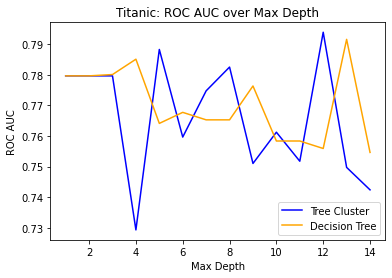

In [14]:
x_lst = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
plt.plot(x_lst, auc_clust, color='blue', label="Tree Cluster")
plt.plot(x_lst, auc, color='orange', label="Decision Tree")
plt.xlabel("Max Depth")
plt.ylabel("ROC AUC")
plt.title("Titanic: ROC AUC over Max Depth")
plt.legend()
plt.show()

## Adult Income

In [17]:
auc_clust_a = []
auc_a = []
for i in range(1, 15):
    print(i)
    auc_clust_a_i = []
    auc_a_i = []
    for j in range(30):
        xTrain, xTest, yTrain, yTest, full_data_train,full_data_test = pre_processing_adult()
        df_train = full_data_train[["income", "age", "workclass", "educational-num", "occupation", "relationship", "race", "gender", "capital-gain", "capital-loss", "hours-per-week", "native-country"]]
        df_test = full_data_test[["income", "age", "workclass", "educational-num", "occupation", "relationship", "race", "gender", "capital-gain", "capital-loss", "hours-per-week", "native-country"]]
        dataset_train = df_train.to_numpy()
        dataset_test = df_test.to_numpy()
        mods,train_final_dist,test_final_dist = fit_random_forest(xTrain,yTrain,100,xTest, i)
        train_final_dist = train_final_dist.groupby(['i1','i2']).mean().reset_index()
        train_final_dist = train_final_dist[['i1', 'i2', 'tree_dist']]
        tree_full = build_tree(dataset_train, df_train, i, 30, train_final_dist)
        ypred_dt = get_pred_lst(tree_full, dataset_test)
        auc_clust_a_i.append(sklearn.metrics.roc_auc_score(yTest,ypred_dt))
    
        clf = DecisionTreeClassifier(max_depth=i, min_samples_split= 30, random_state=0)
        clf.fit(xTrain, yTrain)
        y_pred = clf.predict(xTest)
        auc_a_i.append(sklearn.metrics.roc_auc_score(yTest,y_pred))
    
    auc_clust_a.append(st.mean(auc_clust_a_i))
    auc_a.append(auc_a_i)

1
2
3
4
5
6
7
8
9
10
11
12
13
14


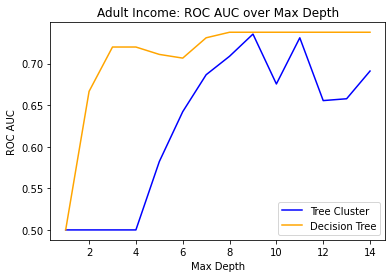

In [18]:
plt.plot(x_lst, auc_clust_a, color='blue', label="Tree Cluster")
plt.plot(x_lst, auc_a, color='orange', label="Decision Tree")
plt.xlabel("Max Depth")
plt.ylabel("ROC AUC")
plt.title("Adult Income: ROC AUC over Max Depth")
plt.legend()
plt.show()

## Heart Disease

In [15]:
auc_clust_h = []
auc_h = []
for i in range(1, 15):
    print(i)
    auc_clust_h_i = []
    auc_h_i = []
    for j in range(30):
        xTrain, xTest, yTrain, yTest, full_data_train,full_data_test = pre_processing_heart()
        df_train = full_data_train[["target", "age", "sex", "cp", "trestbps", "chol", "fbs", "restecg", "thalach", "exang", "oldpeak", "slope", "ca", "thal"]]
        df_test = full_data_test[["target", "age", "sex", "cp", "trestbps", "chol", "fbs", "restecg", "thalach", "exang", "oldpeak", "slope", "ca", "thal"]]
        dataset_train = df_train.to_numpy()
        dataset_test = df_test.to_numpy()
        mods,train_final_dist,test_final_dist = fit_random_forest(xTrain,yTrain,100,xTest, i)
        train_final_dist = train_final_dist.groupby(['i1','i2']).mean().reset_index()
        train_final_dist = train_final_dist[['i1', 'i2', 'tree_dist']]
        tree_full = build_tree(dataset_train, df_train, i, 30, train_final_dist)
        ypred_dt = get_pred_lst(tree_full, dataset_test)
        auc_clust_h_i.append(sklearn.metrics.roc_auc_score(yTest,ypred_dt))
    
        clf = DecisionTreeClassifier(max_depth=i, min_samples_split= 30, random_state=0)
        clf.fit(xTrain, yTrain)
        y_pred = clf.predict(xTest)
        auc_h_i.append(sklearn.metrics.roc_auc_score(yTest,y_pred))
    auc_clust_h.append(st.mean(auc_clust_h_i))
    auc_h.append(st.mean(auc_h_i))

1
2
3
4
5
6
7
8
9
10
11
12
13
14


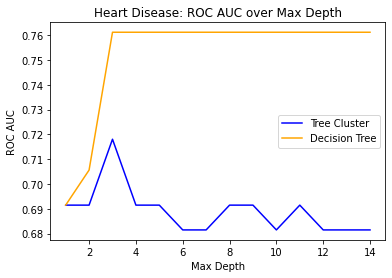

In [16]:
x_lst = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
plt.plot(x_lst, auc_clust_h, color='blue', label="Tree Cluster")
plt.plot(x_lst, auc_h, color='orange', label="Decision Tree")
plt.xlabel("Max Depth")
plt.ylabel("ROC AUC")
plt.title("Heart Disease: ROC AUC over Max Depth")
plt.legend()
plt.show()

In [ ]:
# k means clustering - assigned clsuter label based on training, give each cluster a class label and 
# should 